## Velocyto (implemented in R)
元URL: http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html

最終更新日：2021/4/28

SMART-seq2で得られたE12.5 chromaffinデータを用いた基本的な解析例を示します。
ここでは遺伝子間の相対的な速度 (gene-relative velocity)と、代替の遺伝子構造ベースのモデル (alternative gene-structure based model)を使用して推定する方法を示します。

自分のPCでDockerが起動している状態であることを確認してください。
以降の作業はJupyter (R) 上で行います。

### optional: bamファイルからのデータ生成
（本チュートリアルでは必要ありません）

SMART-seq2は細胞ごとに1つのbamファイルが生成されます。このbamファイルに対して、以下のコマンドを用いてspliced, unspliced, spanningのラベルを各readに付与します。コマンド実行後、以下の2つのファイルを含むvelocytoディレクトリが作成されます。

- onefilepercell_A1_unique_and_others_J2CH1.loom - spliced, unspliced, spanningのマトリックスを含むloomファイル。
- dump/onefilepercell_A1_unique_and_others_J2CH1.hdf5 - 遺伝子構造ベースのモデルのパラメータを推定するために使用する、詳細な分子マッピング情報。velocyto.pyを実行する際には、-d 1オプションを省略することができます。

In [ ]:
# wget http://pklab.med.harvard.edu/velocyto/chromaffin/bams.tar
# tar xvf bams.tar
# velocyto run_smartseq2 -d 1 `find ./ data/e12.5.bams/ -name "*.bam" -print` mm10.genes.gtf

### データ読み込み

In [12]:
# データのダウンロード（１回でよい）
options(timeout=6000)
#download.file("http://pklab.med.harvard.edu/velocyto/chromaffin/ldat.rds", "data/chromaffin.ldat.rds")
#download.file("http://pklab.med.harvard.edu/velocyto/chromaffin/cell.colors.rds", "data/chromaffin.cell.colors.rds")
#download.file("http://pklab.med.harvard.edu/velocyto/chromaffin/embedding.rds", "data/chromaffin.embedding.rds")

In [9]:
library(velocyto.R)

# 発現量データ: 簡単のため、ここでは既に用意されているrdsファイルを読み込む
ldat <- readRDS("data/chromaffin.ldat.rds")

#ldat <- read.loom.matrices("data/velocyto/onefilepercell_A1_unique_and_others_J2CH1.loom")  # 上記のコマンドで生成したloomファイルを読み込む場合

# str関数でオブジェクト ldat の内容を情報付きで表示する
str(ldat)

List of 4
 $ spliced  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:2724270] 3 9 10 13 14 17 19 20 28 29 ...
  .. ..@ p       : int [1:385] 0 7100 14272 21376 28491 36017 43375 50956 57637 64998 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:23420] "Xkr4" "Rp1" "Sox17" "Mrpl15" ...
  .. .. ..$ : chr [1:384] "onefilepercell_A1_unique_and_others_J2CH1:A1_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A10_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A11_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A12_unique.bam" ...
  .. ..@ x       : num [1:2724270] 24 3 22 136 48 21 15 32 109 13 ...
  .. ..@ factors : list()
 $ unspliced:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:1528882] 0 4 10 13 14 17 19 20 23 29 ...
  .. ..@ p       : int [1:385] 0 3911 8043 12057 16176 20795 25046 29389 33438 37382 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@

In [10]:
# 細胞名から余分な文字列を削除
ldat <- lapply(ldat,function(x) {
  colnames(x) <-  gsub("_unique.bam","",gsub(".*:","",colnames(x)))
  x
})

In [14]:
# Read in cell cluster assignment and tSNE embedding used in the Furlan et al. (Science’17).

# 細胞種アノテーション
cell.colors <- readRDS("data/chromaffin.cell.colors.rds")
# 次元削減後の数値
emb <- readRDS("data/chromaffin.embedding.rds")

### Gene filtering

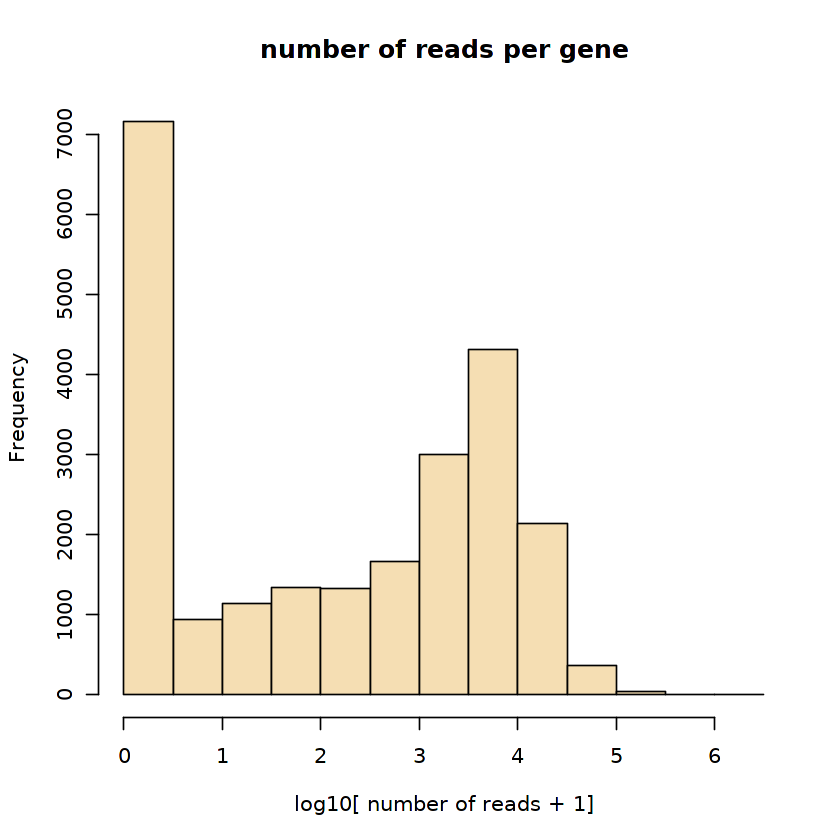

In [16]:
# Spliced expression magnitude distribution across genes:
hist(log10(rowSums(ldat$spliced)+1), 
     col='wheat',
     xlab='log10[ number of reads + 1]',
     main='number of reads per gene')

発現量が閾値以下の遺伝子をフィルタリング：

In [17]:
# exonic read (spliced) expression matrix
emat <- ldat$spliced

# intronic read (unspliced) expression matrix
nmat <- ldat$unspliced

# spanning read (intron+exon) expression matrix
smat <- ldat$spanning

# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat, cell.colors, min.max.cluster.average = 5)
nmat <- filter.genes.by.cluster.expression(nmat, cell.colors, min.max.cluster.average = 1)
smat <- filter.genes.by.cluster.expression(smat, cell.colors, min.max.cluster.average = 0.5)

# look at the resulting gene set
length(intersect(rownames(emat),　rownames(nmat)))

[1] 8548

In [18]:
# and if we use spanning reads (smat)
length(intersect(intersect(rownames(emat), rownames(nmat)), rownames(smat)))

[1] 1696

### gene-relative modelを用いたRNA velocityの推定

ここでは最も頑健な推定手法である cell kNN poolingと 極端な (extreme) 分位数に基づくガンマフィッティングを組み合わせた手法を使います。

min/max 分位点フィットを使用すると、遺伝子のオフセットは spanning reads（smat）フィットを必要としません。ここでは、（ spliced expression magnitudeに基づく）細胞上位/下位5%に基づいてフィットします。



In [19]:
# Several variants of velocity estimates using gene-relative model
# Here the fit is based on the top/bottom 5% of cells (by spliced expression magnitude)
fit.quantile <- 0.05;
rvel.qf <- gene.relative.velocity.estimates(emat, nmat, deltaT=1, kCells = 5, fit.quantile = fit.quantile)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 1306 out of 8548 genes due to low nmat-emat correlation
filtered out 754 out of 7242 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


#### PC5までを使ってRNA速度を可視化

log ... pca ... pc multipliers ... delta norm ... done
done


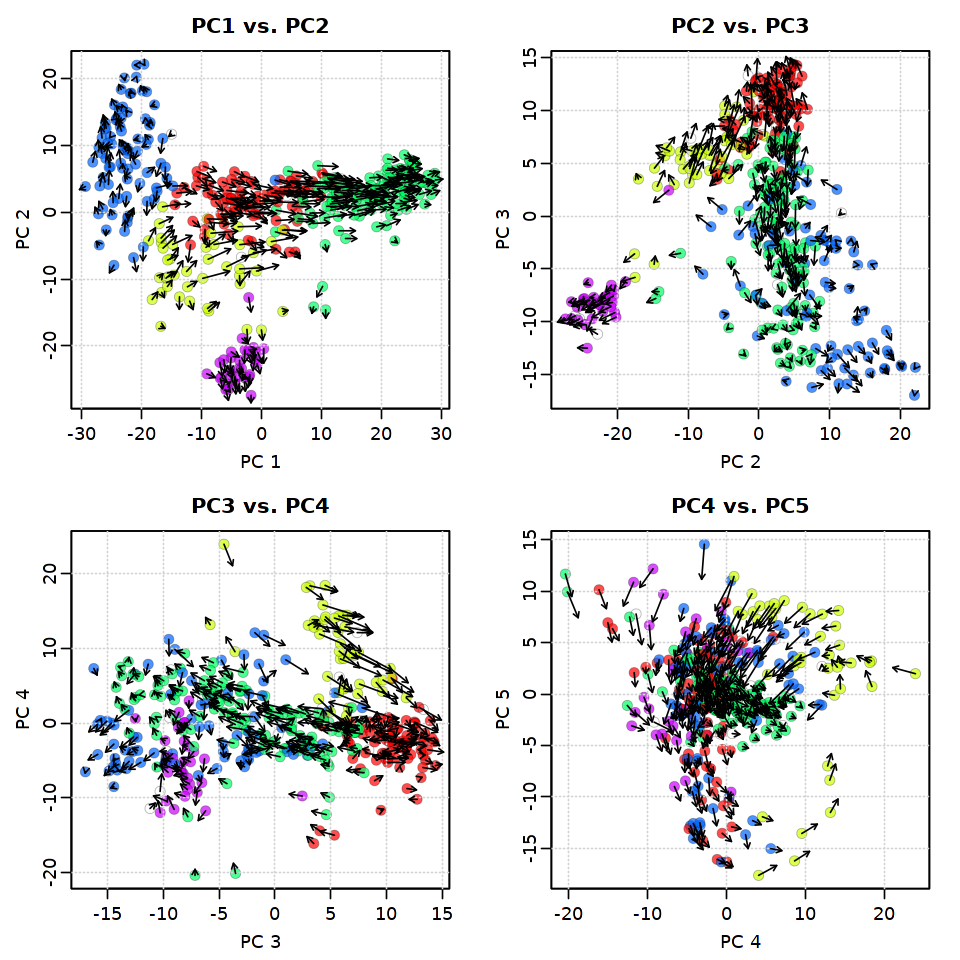

In [29]:
options(repr.plot.width = 8, repr.plot.height = 8)
pca.velocity.plot(rvel.qf, nPcs=5, plot.cols=2,
                  cell.colors=ac(cell.colors, alpha=0.7),
                  cex=1.2, pcount=0.1,
                  pc.multipliers=c(1,-1,-1,-1,-1))

個々の遺伝子のフィッティングは、``show.gene`` オプションを使用して視覚化できます。計算時間を短縮するために、以前に計算した速度(rvel.qf)を渡します。

calculating convolved matrices ... done


[1] 1

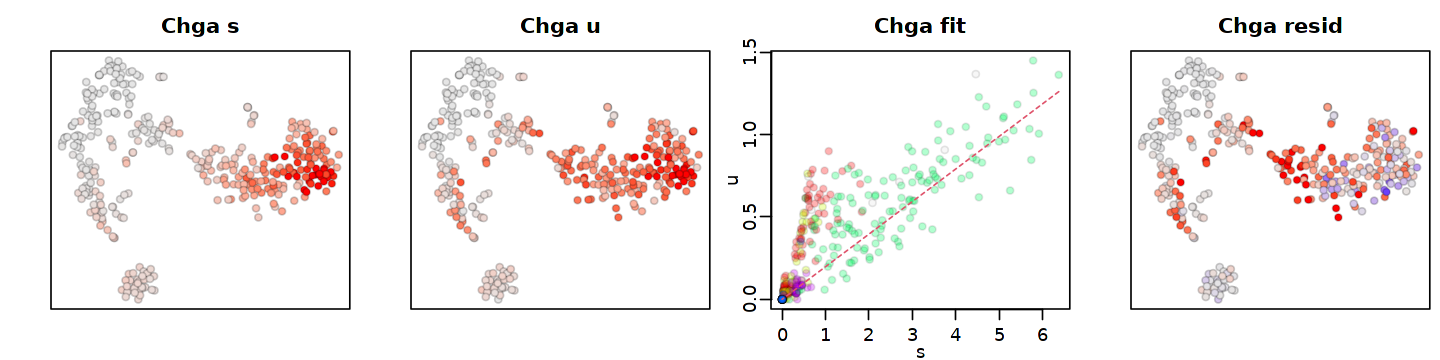

In [26]:
options(repr.plot.width = 12, repr.plot.height = 3)
gene.relative.velocity.estimates(emat, nmat,
                                 kCells = 5,
                                 fit.quantile = fit.quantile,
                                 old.fit=rvel.qf,
                                 show.gene='Chga',
                                 cell.emb=emb,
                                 cell.colors=cell.colors)

または、スパニングリード（smat）を使って遺伝子をフィットさせることもできます。
この方法では、より正確なオフセット推定値が得られますが、対象となる遺伝子の数が非常に少なくなります（スパニングリードは稀です）。
なお、ここでは ``diagona.quantiles``オプションを使用して、splcied/unspliced signal の正規化された合計値に対する極端な分位点を推定しています。

In [27]:
rvel <- gene.relative.velocity.estimates(emat, nmat, smat=smat, 
                                         kCells = 5,
                                         fit.quantile=fit.quantile,
                                         diagonal.quantiles = TRUE)

calculating cell knn ... done
calculating convolved matrices ... done
fitting smat-based offsets ... done
fitting gamma coefficients ... done. succesfful fit for 1696 genes
filtered out 26 out of 1696 genes due to low nmat-smat correlation
filtered out 138 out of 1670 genes due to low nmat-emat correlation
filtered out 14 out of 1532 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


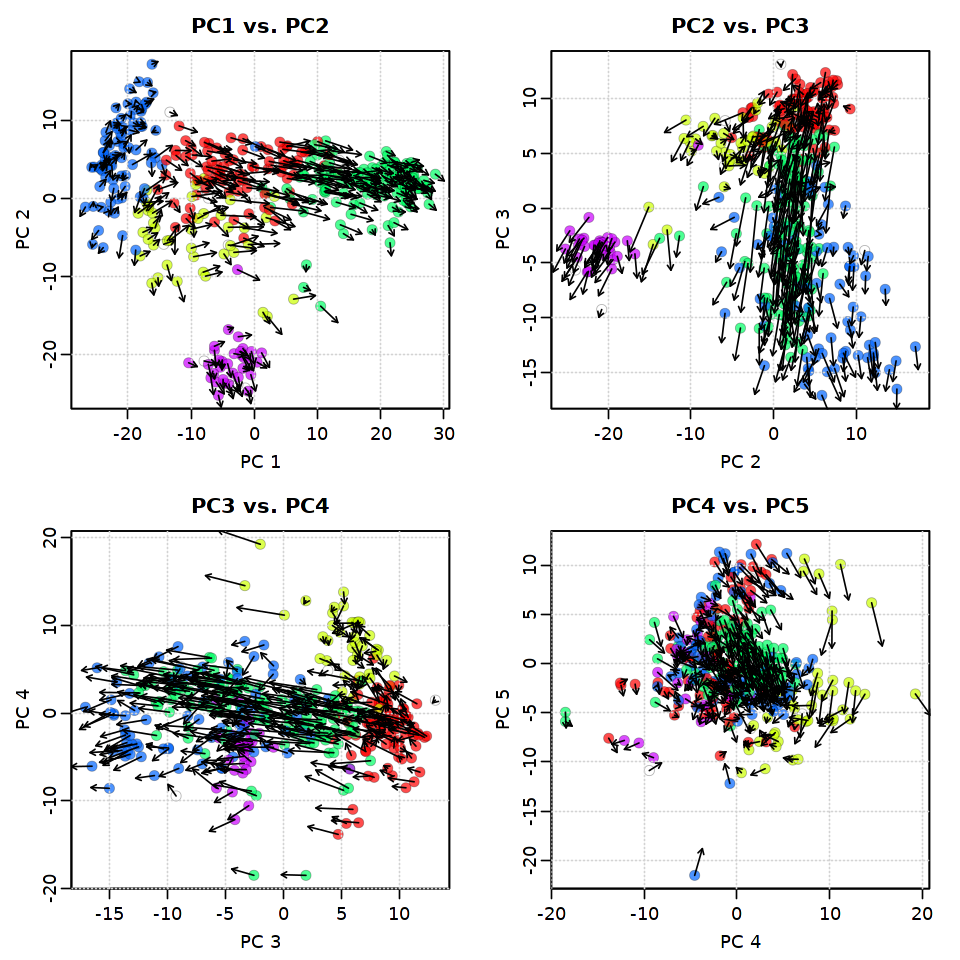

In [31]:
options(repr.plot.width = 8, repr.plot.height = 8)
pca.velocity.plot(rvel, nPcs=5,
                  plot.cols=2,
                  cell.colors=ac(cell.colors,alpha=0.7),
                  cex=1.2,
                  pcount=0.1,
                  pc.multipliers=c(1,-1,1,1,1))

ここでは、cell kNN smoothingを行わずに、相対的ガンマフィッティングを用いて最も基本的なバージョンの速度推定値を計算します（つまり、実際のシングルセルの速度です）。

In [32]:
rvel1 <- gene.relative.velocity.estimates(emat,
                                          nmat,
                                          deltaT=1,
                                          deltaT2 = 1,
                                          kCells = 1,
                                          fit.quantile=fit.quantile)

fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 783 out of 8548 genes due to low nmat-emat correlation
filtered out 1330 out of 7765 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


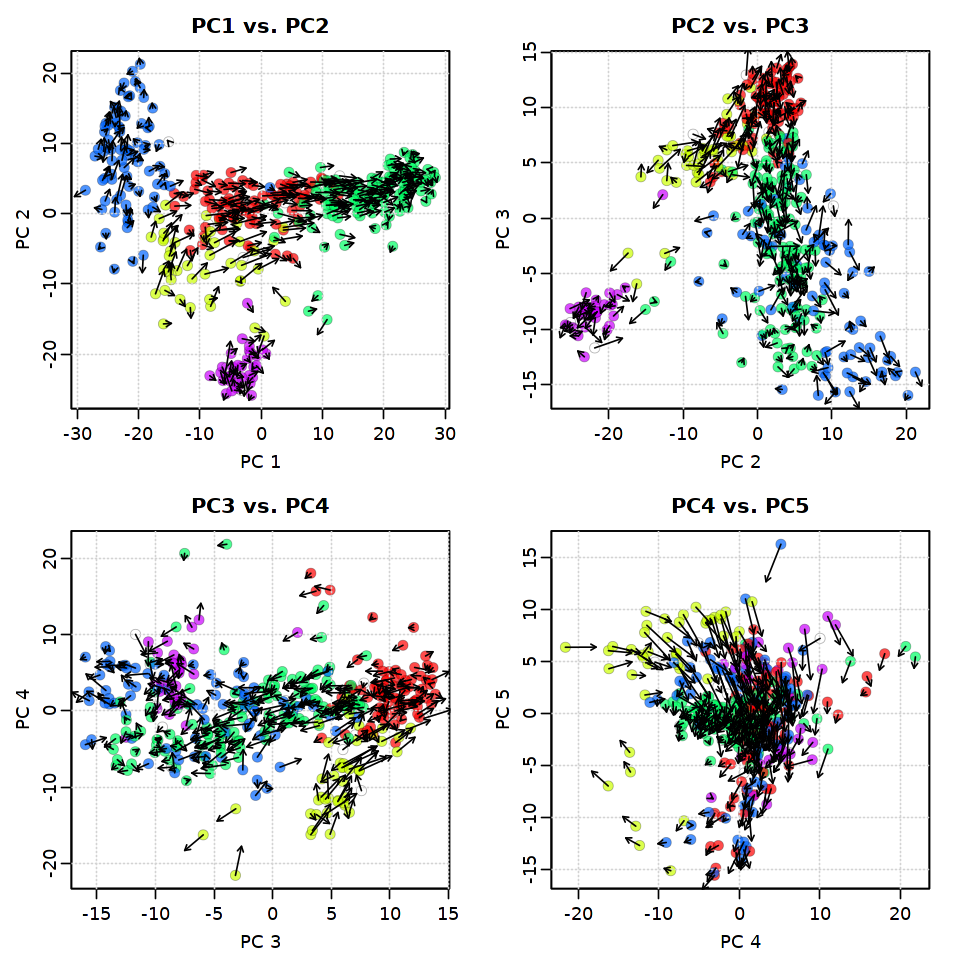

In [33]:
options(repr.plot.width = 8, repr.plot.height = 8)
pca.velocity.plot(rvel1,nPcs=5,
                  plot.cols=2,
                  cell.colors=ac(cell.colors,alpha=0.7),
                  cex=1.2,pcount=0.1,
                  pc.multipliers=c(1,-1,1,1,1))

#### tSNE上での可視化

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


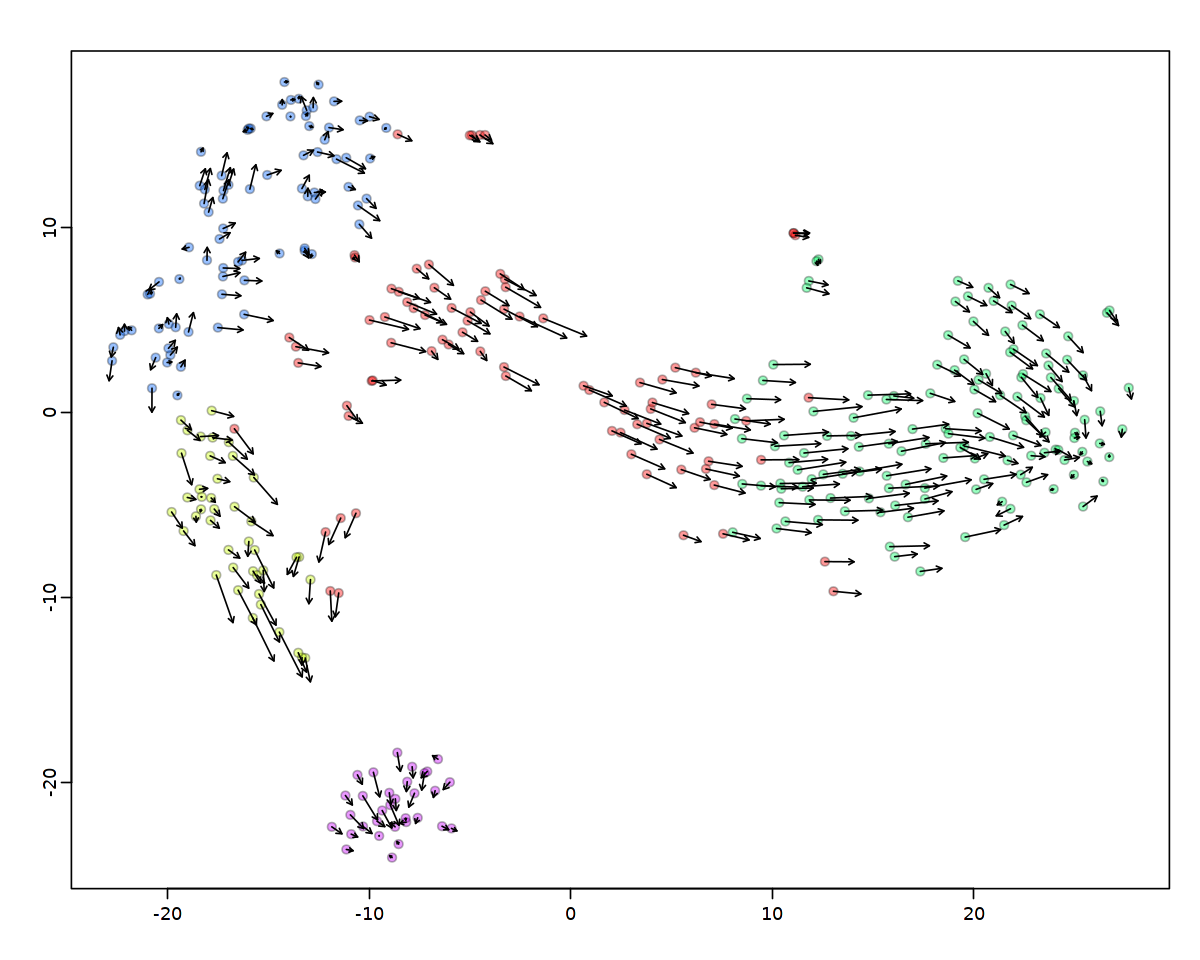

In [38]:
vel <- rvel; arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;

options(repr.plot.width = 10, repr.plot.height = 8)
show.velocity.on.embedding.cor(emb,
                               vel,
                               n = 100,
                               scale = 'sqrt',
                               cell.colors = ac(cell.colors, alpha=cell.alpha),
                               cex = cell.cex,
                               arrow.scale = arrow.scale,
                               arrow.lwd = 1)

または同じ関数を使用して、RNA速度ベクトルフィールド（全体的な速度の流れ）を計算することもできます。

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... grid.sd= 1.731696  min.arrow.size= 0.03463392  max.grid.arrow.length= 0.1013337  done


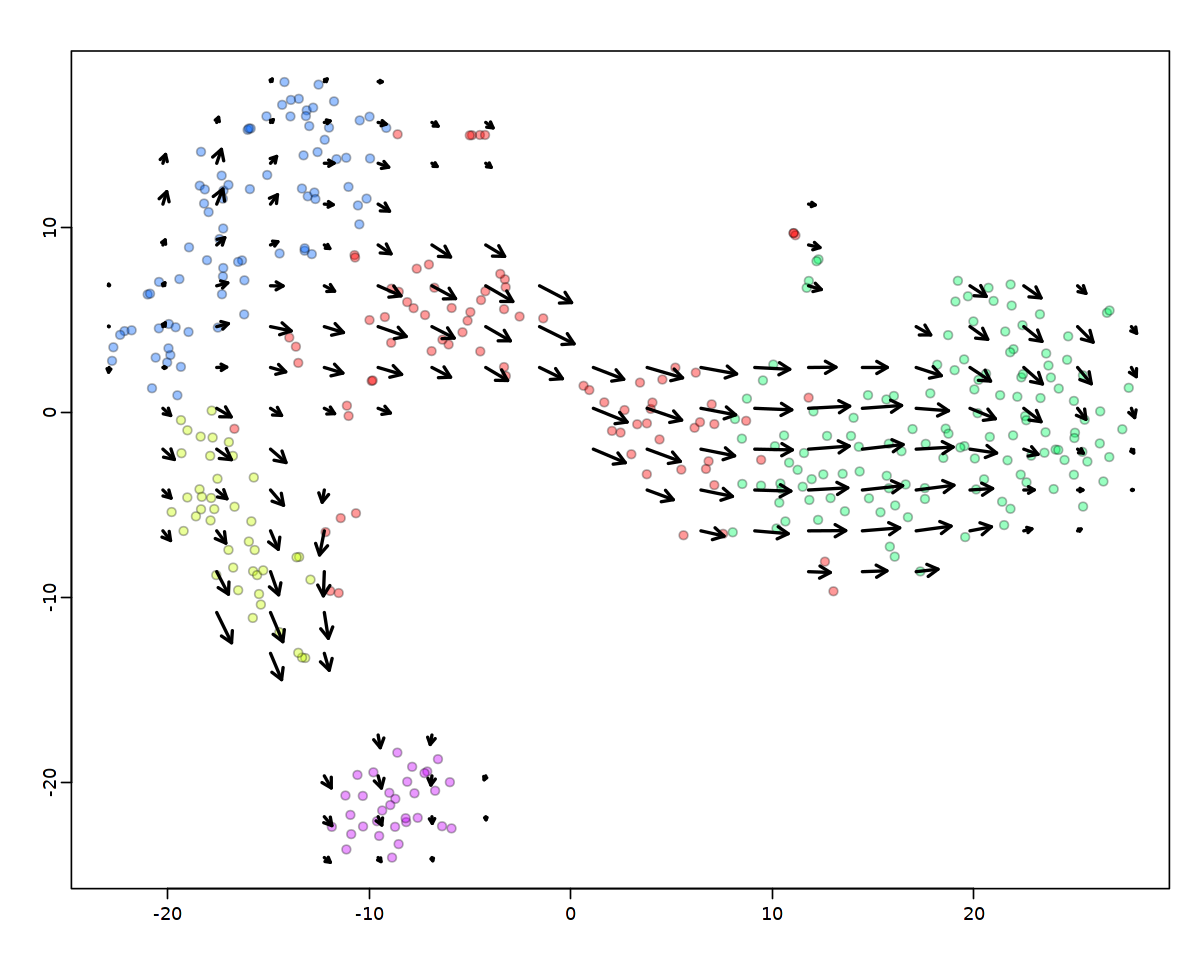

In [39]:
show.velocity.on.embedding.cor(emb,
                               vel,
                               n = 100, scale = 'sqrt',
                               cell.colors = ac(cell.colors, alpha=cell.alpha),
                               cex = cell.cex,
                               arrow.scale = arrow.scale,
                               show.grid.flow = TRUE,
                               min.grid.cell.mass = 0.5,
                               grid.n = 20,
                               arrow.lwd = 2)

### 遺伝子構造に基づくRNA速度推定

遺伝子構造パラメータに基づいて速度を推定する場合は遺伝子アノテーションデータ(gtfファイル) を解析するとともに、エクソン単位のマッピング情報（velocyto.pyの-dオプションで得られるデバッグ用hdf5出力）を解析する必要があります。

まず最初に、ゲノム（マウスUCSC mm10）で予想される内部プライミングサイトの情報をまとめておきます。

In [42]:
# gtfファイルの解析する場合
# require(BSgenome.Mmusculus.UCSC.mm10)
# ip.mm10 <- find.ip.sites('data/genes.gtf', Mmusculus, 'mm10')

# 既に計算された遺伝子データを用いる場合
ip.mm10 <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/ip.mm10.rds"))

In [44]:
# exon情報のロード（上記のbamからの計算を行った場合）
#gene.info <- read.gene.mapping.info("data/velocyto/dump/onefilepercell_A1_unique_and_others_J2CH1.hdf5",
#                                    internal.priming.info=ip.mm10,min.exon.count=10)

# 既に計算されたデータを用いる場合
gene.info <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/gene.info.rds"))

In [45]:
# ここではより多くの遺伝子を利用するためフィルタ前のデータを入力に用いる
emat <- ldat$spliced; nmat <- ldat$unspliced; smat <- ldat$spanning
emat <- filter.genes.by.cluster.expression(emat, cell.colors, min.max.cluster.average = 7)
gvel <- global.velcoity.estimates(emat,
                                  nmat, 
                                  rvel, 
                                  base.df = gene.info$gene.df,
                                  smat = smat,
                                  deltaT = 1,
                                  kCells = 5,
                                  kGenes = 15,
                                  kGenes.trim = 5,
                                  min.gene.cells = 0,
                                  min.gene.conuts = 500)

filtered out 4 out of 8990 genes due to low emat levels
filtered out 1072 out of 8986 genes due to insufficient exonic or intronic lengths
filtered out 204 out of 7914 genes due to excessive nascent counts
using relative slopes for 1221 genes to fit structure-based model ... with internal priming info ... 80.5% deviance explained.
predicting gamma ... done
refitting offsets ... calculating cell knn ... done
calculating convolved matrices ... done
fitting smat-based offsets ... done
fitting gamma coefficients ... done. succesfful fit for 7694 genes
filtered out 1337 out of 7551 genes due to low nmat-smat correlation
filtered out 899 out of 6214 genes due to low nmat-emat correlation
filtered out 440 out of 5315 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done
re-estimated offsets for 6214 out of 7710 genes
calculating convolved matrices ... done
calculating gene knn ... done
estimating M values ... adjusting mval offse

log ... pca ... pc multipliers ... delta norm ... done
done


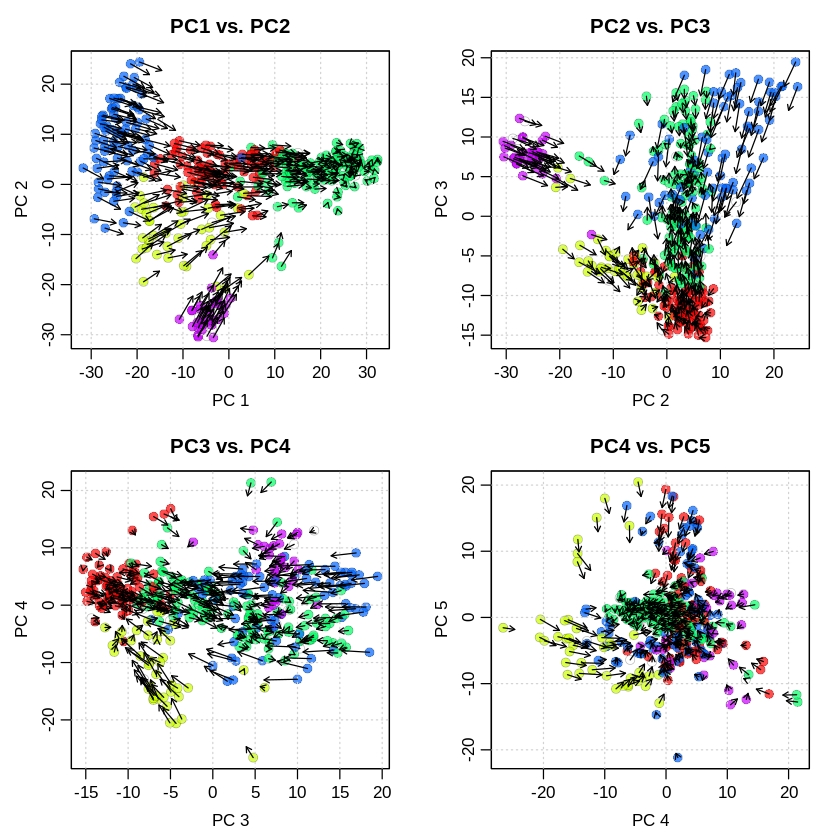

In [26]:
options(repr.plot.width = 8, repr.plot.height = 8)
pca.velocity.plot(gvel,
                  nPcs = 5,
                  plot.cols = 2,
                  cell.colors = ac(cell.colors,alpha=0.7),
                  cex = 1.2,
                  pcount = 0.1,
                  pc.multipliers = c(1,-1,-1,1,1))

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


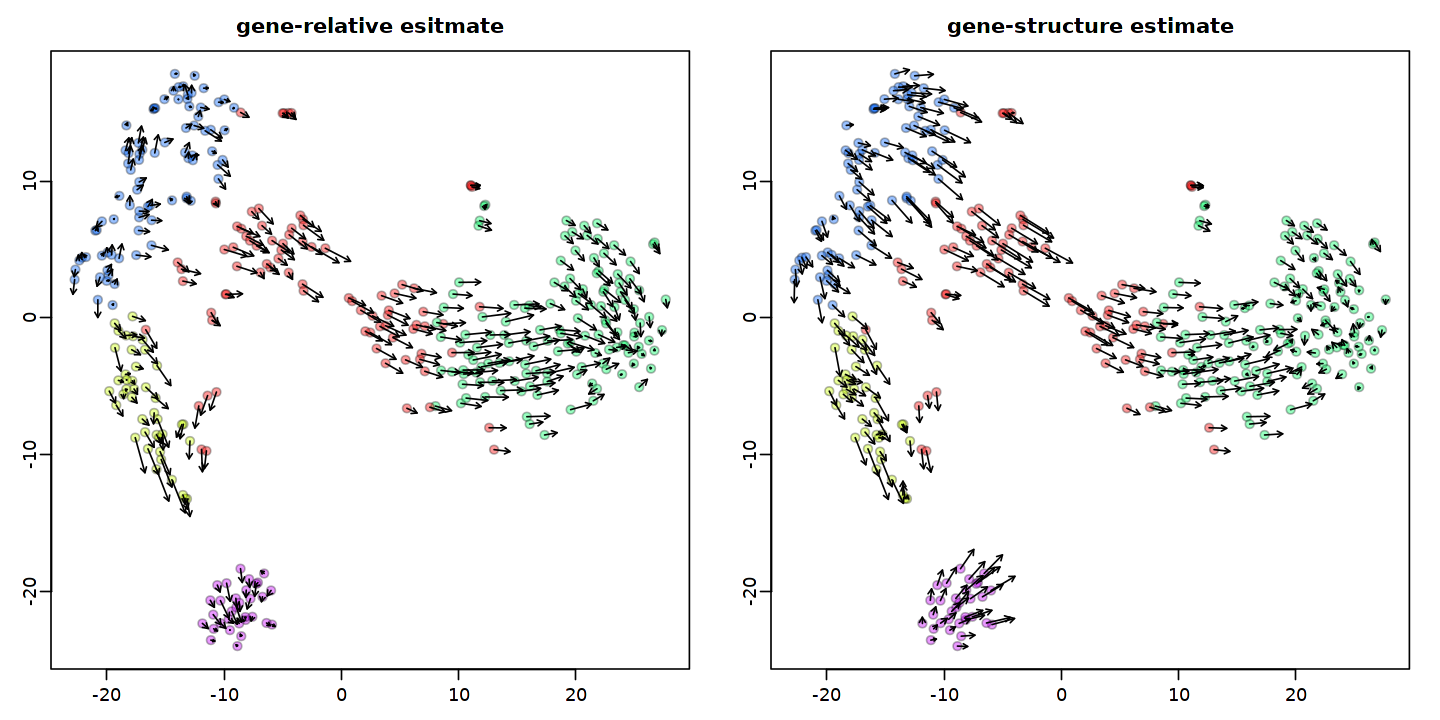

In [48]:
# gene-relativeとgene-structureの推定値の比較

par(mfrow=c(1,2), mar = c(2.5,2.5,2.5,1.5), mgp = c(2,0.65,0), cex = 0.85);
arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;

options(repr.plot.width = 12, repr.plot.height = 6)
#pdf(file='tsne.rvel_gvel.plots.pdf',height=6,width=12)
show.velocity.on.embedding.cor(emb, rvel, n=100,scale='sqrt', cell.colors=ac(cell.colors, alpha=cell.alpha), cex=cell.cex, arrow.scale=arrow.scale, arrow.lwd=1, main='gene-relative esitmate', do.par=F)
show.velocity.on.embedding.cor(emb, gvel, n=100,scale='sqrt', cell.colors=ac(cell.colors, alpha=cell.alpha), cex=cell.cex, arrow.scale=arrow.scale, arrow.lwd=1, main='gene-structure estimate',do.par=F)
#dev.off()

rescaling ... log ... pca ... delta norm ... tSNE ...Performing PCA
Read the 768 x 15 data matrix successfully!
OpenMP is working. 40 threads.
Using no_dims = 2, perplexity = 200.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 1.32 seconds (sparsity = 0.903880)!
Learning embedding...
Iteration 50: error is 45.227905 (50 iterations in 16.44 seconds)
Iteration 100: error is 45.227225 (50 iterations in 17.05 seconds)
Iteration 150: error is 44.505696 (50 iterations in 16.80 seconds)
Iteration 200: error is 44.370222 (50 iterations in 17.43 seconds)
Iteration 250: error is 44.370472 (50 iterations in 17.25 seconds)
Iteration 300: error is 0.175259 (50 iterations in 17.73 seconds)
Iteration 350: error is 0.165698 (50 iterations in 17.28 seconds)
Iteration 400: error is 0.164890 (50 iterations in 17.87 seconds)
Iteration 450: error is 0.164112 (50 iterations in 17.93 seconds)
Iteration 500: error is 0.163372 (50 iterations in 17.64 seconds)
Iteration 550

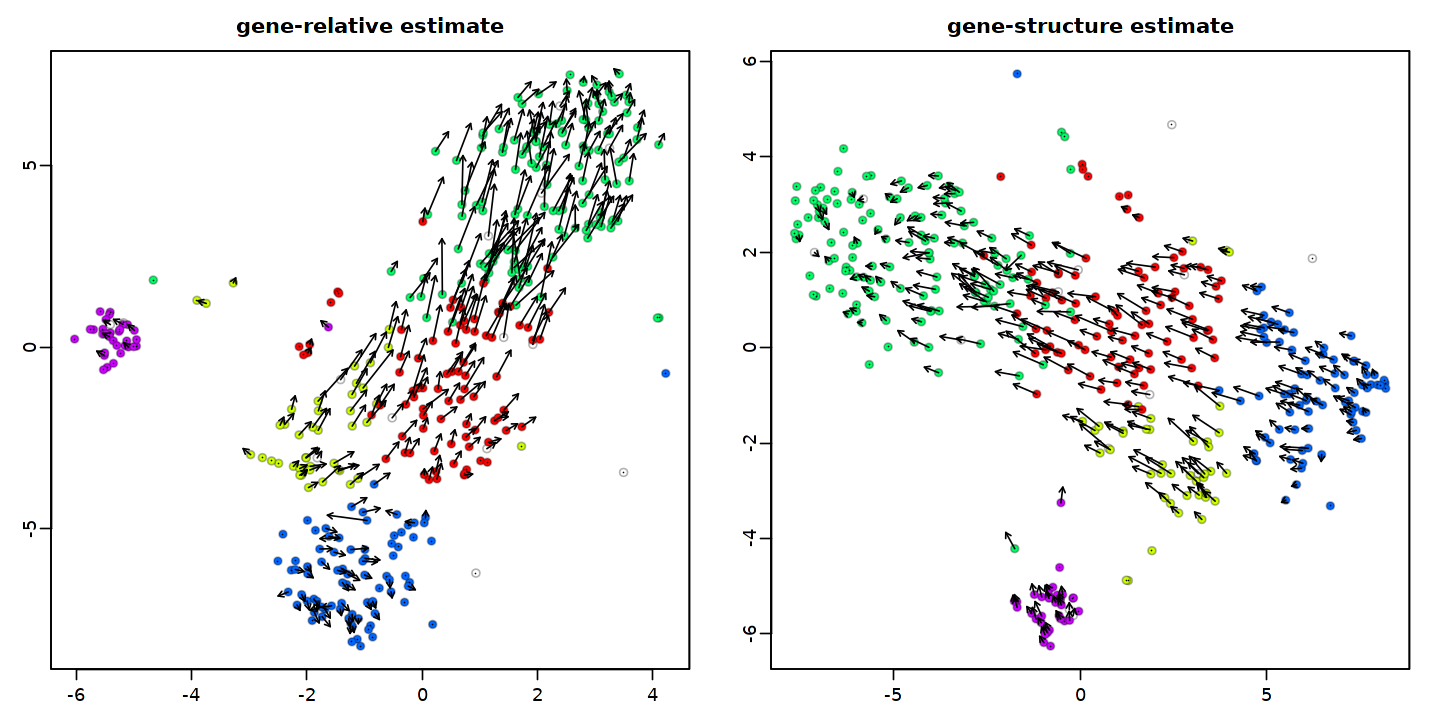

In [52]:
# あるいは、観測されたセルと外挿されたセルの両方を同じtSNE空間に共同で埋め込む

#pdf(file='tsne.shift.plots.pdf',height=6,width=12)
par(mfrow=c(1,2), mar = c(2.5,2.5,2.5,1.5), mgp = c(2,0.65,0), cex = 0.85);
x <- tSNE.velocity.plot(rvel, nPcs=15, cell.colors=cell.colors, cex=0.9, perplexity=200, norm.nPcs=NA, pcount=0.1, scale='log', do.par=F, main='gene-relative estimate')
x <- tSNE.velocity.plot(gvel, nPcs=15, cell.colors=cell.colors, cex=0.9, perplexity=200, norm.nPcs=NA, pcount=0.1, scale='log', do.par=F, main='gene-structure estimate')

#dev.off()

### Cell trajectory modeling

同じ関数を使って、埋め込まれた二次元空間上での有向性拡散 (directed diffusion)による中心的な軌跡をモデル化することができます。

主なパラメータは、``sigma``（セルがジャンプできる距離の範囲を制限するもの）と``n``（ジャンプの際に考慮される最近傍の数）です。
結果はこれらのパラメータに敏感に反応します。というのも、速度成分が、多様体上の細胞のランダムなブラウン運動と比較してどの程度のものかを評価する良い方法がないからです。
例えば、特に``sigma``を緩和（増加）させると、交感神経芽細胞は最終的にクロマフィン分化部へのギャップを「ジャンプ」することになる。

sqrt scale ... reducing to 30 PCs ... distance ... sigma= 2.5  beta= 1  transition probs ... embedding kNN ... done
simulating diffusion ... constructing path graph ... tracing shortest trajectories ... clustering ... done.


Warning message in arrows(bp$x[ai], bp$y[ai], bp$x[ai + 1], bp$y[ai + 1], angle = 30, :
“zero-length arrow is of indeterminate angle and so skipped”


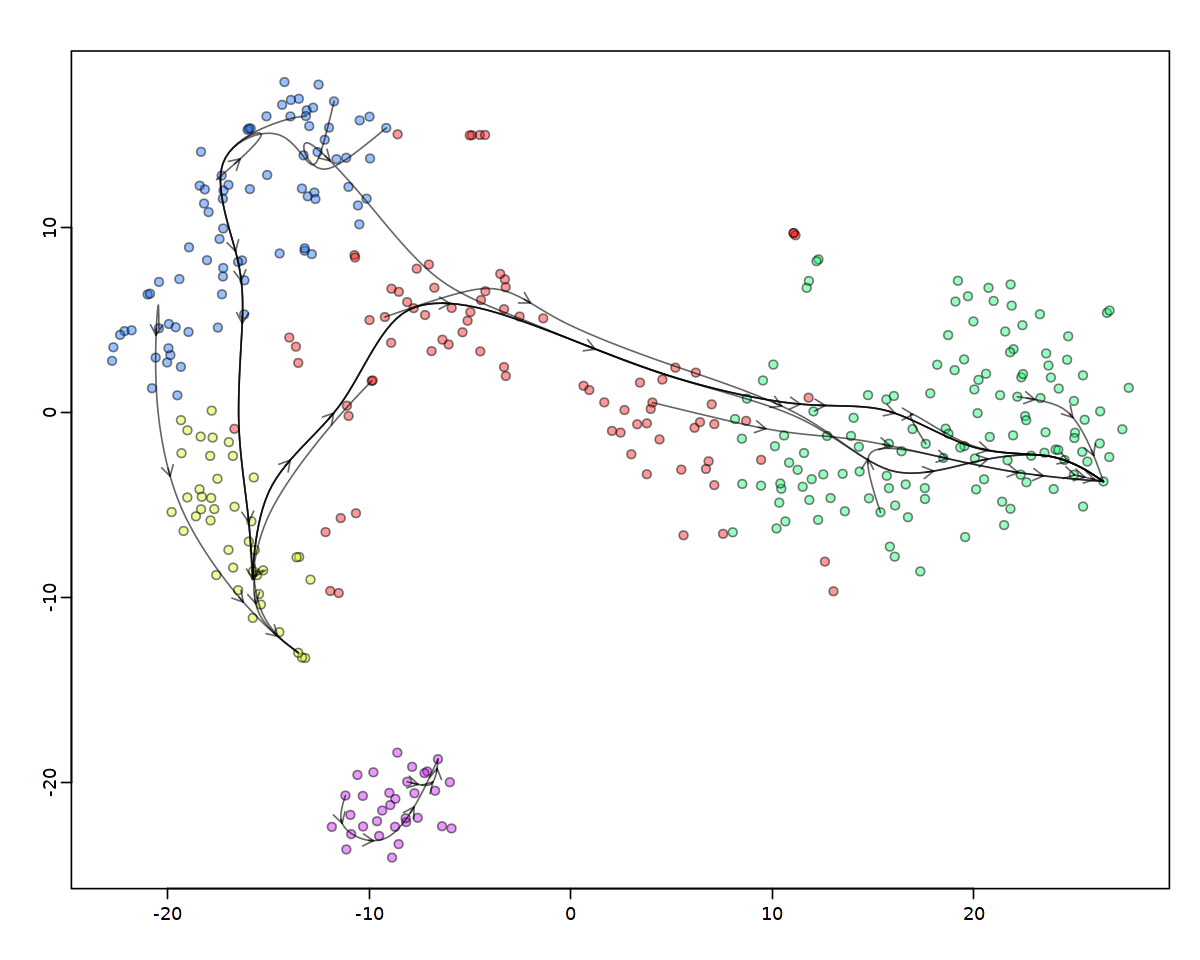

In [54]:
options(repr.plot.width = 10, repr.plot.height = 8)
x <- show.velocity.on.embedding.eu(emb,
                                   rvel,
                                   n = 40,
                                   scale = 'sqrt',
                                   cell.colors = ac(cell.colors,alpha = cell.alpha),
                                   cex = cell.cex,
                                   nPcs = 30,
                                   sigma = 2.5,show.trajectories = TRUE,
                                   diffusion.steps = 400,
                                   n.trajectory.clusters = 15,
                                   ntop.trajectories = 1,
                                   embedding.knn = T,
                                   control.for.neighborhood.density = TRUE,
                                   n.cores = 16) 

In [55]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm10_1.4.0 BSgenome_1.58.0                   
 [3] rtracklayer_1.50.0                 Biostrings_2.58.0                 
 [5] XVector_0.30.0                     GenomicRanges_1.42.0              
 [7] GenomeInfoDb